# Segmentación por color

Partimos de una imagen que tiene varias zonas de interés, en este caso "vegetación" y "tierra", y tratamos de distinguirlas usando un modelo de color sencillo. (El código siguiente funcionará igual si hay más de dos clases.)

In [1]:
import numpy             as np
import cv2               as cv
import skimage           as si
import matplotlib.pyplot as plt
import ipywidgets
from matplotlib.pyplot import imshow, subplot, title

%matplotlib inline

In [2]:
def fig(w,h):
    return plt.figure(figsize=(w,h))

def readrgb(file):
    return cv.cvtColor( cv.imread("../images/"+file), cv.COLOR_BGR2RGB) 

def rgb2yuv(x):
    return cv.cvtColor(x,cv.COLOR_RGB2YUV)

def yuv2rgb(x):
    return cv.cvtColor(x,cv.COLOR_YUV2RGB)

byte = np.uint8

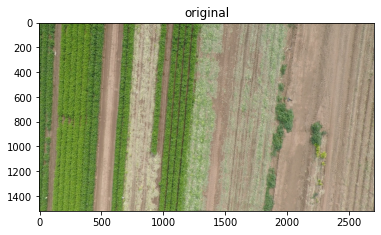

In [3]:
img = readrgb("d1.jpg")
imshow(img); title('original');
rows,cols,d = img.shape

Recortamos un trozo de cada región.

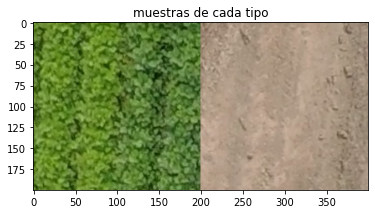

In [4]:
r1 = img[200:400,300:500]
r2 = img[200:400,2100:2300]
models = [r1,r2]

imshow(np.hstack(models)); title('muestras de cada tipo');

## Modelo muy simple

Una primera idea sería calcular el color "típico" (medio) de cada región y clasificar los pixels por mínima distancia.

In [5]:
med = [ np.mean(r,(0,1)) for r in models ]

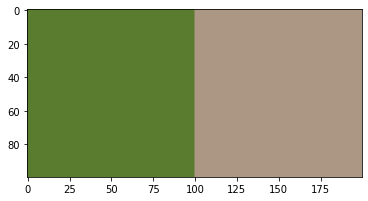

In [6]:
# mostramos unos cuadritos del color medio de cada región

muestras = []
for color in med:
    x = np.zeros([100,100,3],byte)
    x[:,:] = color
    muestras.append(x)

imshow(np.hstack(muestras));

Calculamos las diferencias absolutas de los pixels RGB y cada color medio:

In [45]:
d = [ np.sum(abs(img - m), axis=2) for m in med ]

Para cada pixel calculamos en qué modelo se obtiene el valor mínimo de distancia:

In [48]:
c  = np.argmin(d, axis=0)

Esta imagen de etiquetas se puede mostrar ya directamente. Matplotlib autoescala los valores 0,1,... encontrados y los reparte entre negro y blanco.

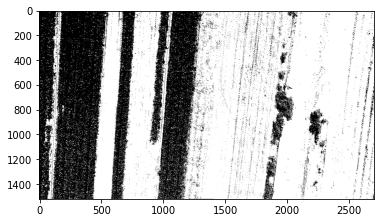

In [9]:
imshow(c,'gray');

Pero es mejor representar cada pixel con el color medio de la categoría asignada. Para ello, preparamos una imagen para contener el resultado

In [10]:
res = np.zeros(img.shape, byte)

Y la rellenamos:

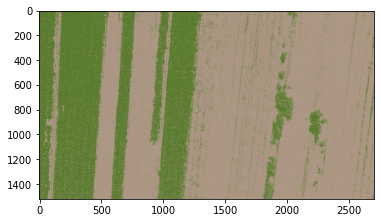

In [11]:
for k in range(len(models)):
    res[c==k] = med[k]

imshow(res);

En este resultado se han clasificado todos los pixels, lo que no tiene mucho sentido. Deberíamos eliminar los que no pertenecen a ningún modelo (aquellos cuya distancia mínima sea grande) y los dudosos (los que están a una distancia parecida de varios modelos). Esto lo haremos correctamente más adelante. Por ahora simplemente eliminamos los que tienen una distancia menor "grande".

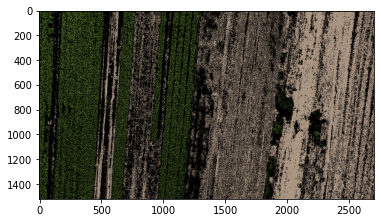

In [12]:
md = np.min(d, axis=0)

res [md > 40] = 0,0,0

imshow(res);

No está mal, pero no está claro cuál es el umbral de distancia más adecuado.

Vamos a intentar construir un modelo de color que tenga en cuenta los matices de color de cada región y usaremos un método de clasificación más preciso.

## Clasificación probabilística

Nuestro objetivo es clasificar los pixels de la imagen de acuerdo con la clase más probable. Las clases son las distintas distribuciones de color extraídas de las regiones seleccionadas. Para ello necesitamos una estimación de la probabilidad de que un pixel sea de la clase $C$ si tiene color $p$ (sus valores RGB, ó UV, etc.):

$$\mathcal P(C \mid p)$$

Esto se puede calcular así (regla de Bayes):

$$\mathcal P(C \mid p) = \frac{\mathcal P(p \mid C)\; \mathcal P(C)}{ \mathcal P(p)} $$

$ \mathcal P(C) $ es la probabilidad *a priori* de la clase $C$. Si no se dice otra cosa, podemos suponer que todas las clases son igualmente probables.


El denominador es la probabilidad de observar ese pixel en cualquiera de las clases. Se calcula como la suma de todos los numeradores.

$$\mathcal P(p) = \sum_C \mathcal P(p \mid C) \; \mathcal P(C)$$

(Si es cero o muy pequeño nos indica que no podemos clasificar el pixel $p$, porque su color no se ha visto en ninguno de los modelos que estamos considerando.)

Por tanto, la clave está en conseguir una estimación de los términos $\mathcal P(p \mid C)$, la probabilidad de observar el color $p$ en cada cada clase C. Es el *modelo de medida*. Nos da la distribución de colores en cada clase.

La forma más sencilla de estimar este modelo es usar un *histograma*, que nos da las frecuencias de cada color en un espacio discretizado, y que podemos suponer parecidas a la probabilidad real. (Los histogramas solo son prácticos en espacios de dimensión muy pequeña, ya que el número de "cajas" crece exponencialmente.)

En la práctica, dado un pixel $p$ que queremos clasificar, lo único que debemos hacer es preguntarle a los histogramas de cada clase la frecuencia con que se observó $p$ y elegir la clase que tenga mayor valor. (Si las probabilidades "a priori" son distintas hay que multiplicar por ellas).

Simplemente hay que tener en cuenta que debemos rechazar la clasificación de los pixels que tengan un valor muy pequeño de $\mathcal P(p)$, y que dividiendo por este valor conseguimos las probabilidades de cada clase.

Estas operaciones se pueden hacer de manera muy simple utilizando numpy.

En este ejemplo vamos a modelar la distribución de colores de las clases mediante histogramas de los valores conjuntos de los canales UV del espacio YUV. La idea es quitar la componente de luminosidad y quedarnos solo con la información de color, para que las sombras o la cantidad total de luz no influyan. (Esto no funcionará bien para distinguir zonas con tonos de blanco, negro o gris.)

In [13]:
# calcula el histograma (normalizado) de los canales conjuntos UV
def uvh(x):
    
    # normalizar un histograma
    # para tener frecuencias (suman 1)
    # en vez de número de elementos
    def normhist(x): return x / np.sum(x)
    
    yuv = rgb2yuv(x)
    h = cv.calcHist([yuv]     # necesario ponerlo en una lista aunque solo admite un elemento
                    ,[1,2]    # elegimos los canales U y V
                    ,None     # posible máscara
                    ,[32,32]  # las cajitas en cada dimensión
                    ,[0,256]+[0,256] # rango de interés (todo)
                   )
    return normhist(h)

Con esta función obtenemos los modelos de color de todas las regiones:

In [14]:
hist = [uvh(r) for r in models]

El significado del histograma 2D es el siguiente. Por ejemplo, el valor

In [15]:
hist[0][15,10]

0.0

significa que en la región "vegetación" la frecuencia con la que han aparecido colores que tienen un valor de U entre $14 \times 8$ y $15 \times 8$ y a la vez un valor de V entre $9 \times 8$ y $10 \times 8$ es del 21%.

Como el histograma es 2D, podemos mostrarlo con barras verticales que indican la frecuencia de cada "caja de color".

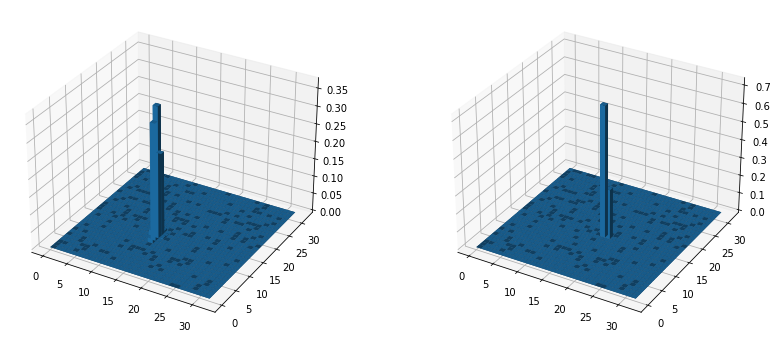

In [16]:
from mpl_toolkits.mplot3d import Axes3D
fg = plt.figure(figsize=(14, 6))

_xx, _yy = np.meshgrid(np.arange(32), np.arange(32))
x, y = _xx.ravel(), _yy.ravel()
bottom = 0
width = depth = 1

ax1 = fg.add_subplot(121, projection='3d')
top = hist[0].ravel()
ax1.bar3d(x, y, bottom, width, depth, top , shade=True);

ax1 = fg.add_subplot(122, projection='3d')
top = hist[1].ravel()
ax1.bar3d(x, y, bottom, width, depth, top, shade=True);

Otra posibilidad es mostrarlos como imágenes, transformando a escala logarítmica para que no solo se vean bien los picos más altos.)

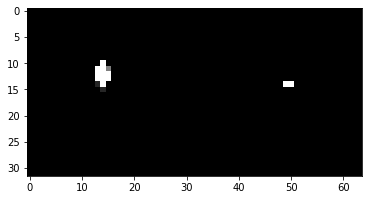

In [17]:
plt.set_cmap('gray')
plt.imshow(np.hstack([np.log(1+h) for h in hist]),vmax=1E-3);

Podemos añadir el el color típico de cada celda.

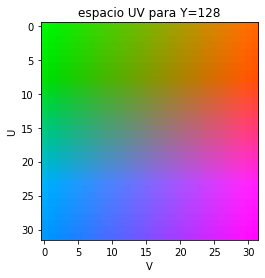

In [18]:
uv = np.zeros([32,32,3],dtype=np.uint8)
ran = np.linspace(0,256-8,32)+4
(v,u) = np.meshgrid(ran,ran)

uv[:,:,0] = 128
uv[:,:,1] = u
uv[:,:,2] = v

plt.imshow(yuv2rgb(uv)); plt.xlabel('V'); plt.ylabel('U'); plt.title('espacio UV para Y=128');
# consistente con la matriz de histograma, no con valores reales de UV.

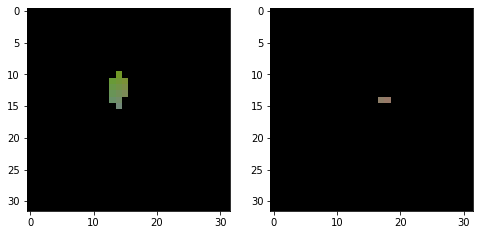

In [19]:
vhist = [ yuv2rgb(uv) * (h > 0).reshape(32,32,1) for h in hist]

fig(8,4)
subplot(1,2,1); imshow(vhist[0]);
subplot(1,2,2); imshow(vhist[1]);

Aquí vemos los dos histogramas juntos, donde se observa que los colores de las regiones seleccionadas están bien separados (aunque no muy alejados) en el espacio UV.

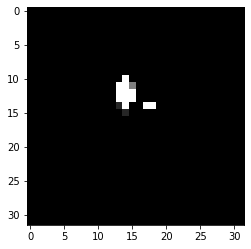

In [20]:
imshow(np.maximum(np.log(1+hist[0]),np.log(1+hist[1])),vmax=1E-3);

En  este ejemplo las distribuciones de las dos clases son bastante compactas, lo que significa que el valor medio podría ser suficiente. (Los modelos de histograma tienen ventajas cuando las distribuciones son más complejas.)

Ahora convertimos al espacio UV la imagen completa que queremos "segmentar" (clasificar). Tenemos que dividir por 8 (cociente de la división entera) para obtener los índices correctos de la caja del histograma. Recordad que usamos 32 divisiones en cada dimensión. (Estamos despreciando los 3 bits menos significativos del los valores de U y V).

In [21]:
# canales UY reducidos a una resolución de 5 bits (32 niveles)
uvr = np.floor_divide( cv.cvtColor(img,cv.COLOR_RGB2YUV)[:,:,[1,2]], 8)
print(uvr.shape, uvr.dtype)

(1520, 2704, 2) uint8


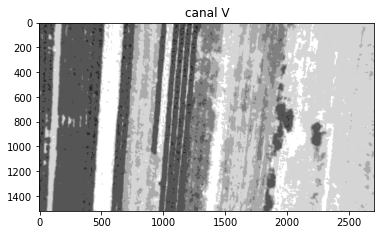

In [22]:
imshow(uvr[:,:,1]); title('canal V');

Ya solo tenemos que consultar, para cada pixel de la imagen, los histogramas de cada región, que nos dirán la "verosimilitud" de cada clase en ese punto. Para ello aprovechamos la potencia expresiva de numpy, indexando los histogramas con toda la imagen. (Esta operación puede hacerse también usando la función de opencv [histogram backprojection](http://docs.opencv.org/3.1.0/dc/df6/tutorial_py_histogram_backprojection.html).)

In [39]:
u = uvr[:,:,0]
v = uvr[:,:,1]

lik = [ h[u,v] for h in hist ]

Ahora tenemos para cada clase, una imagen float que nos indica en cada punto lo verosímil que es. Opcionalmente podemos suavizarla un poco para hacer que los pixels vecinos influyan un poco en los casos dudosos.

In [31]:
lik = [ cv.GaussianBlur(l, (0,0), 10) for l in lik ]

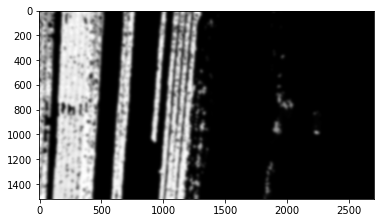

In [32]:
imshow(lik[0], 'gray');

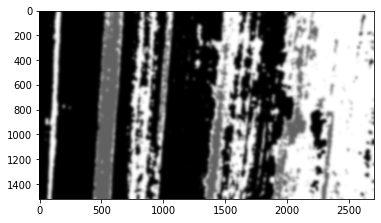

In [36]:
imshow(lik[1], 'gray');

Ahora necesitamos el denominador $\mathcal P(p)$, o "evidencia" de cada punto. 

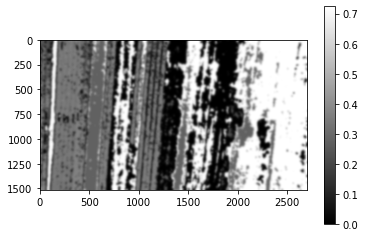

In [38]:
E = np.sum(lik, axis=0)
imshow(E,'gray'); plt.colorbar();

Que nos permite normalizar las verosimilitudes y conseguir probabilidades:

In [41]:
p = np.array(lik) / E

C:\Users\Carlos\AppData\Local\Temp/ipykernel_18880/4056188545.py:1: RuntimeWarning: invalid value encountered in true_divide
  p = np.array(lik) / E


Se produce un warning debido a las divisiones por cero. No nos preocupa porque luego vamos a eliminar los puntos problemáticos, desconocidos para nuestros modelos.

Las probabilidades se han guardado en un array 3D. La clasificación se realiza obteniendo en cada punto la clase que tiene mayor probabilidad, lo que se puede conseguir directamente con la función `np.argmax`.

In [44]:
c  = np.argmax(p,axis=0)

También necesitamos el valor de la probabilidad ganadora en cada punto (eliminando las divisiones por cero).

In [51]:
mp = np.max(p, axis=0)
mp[E < 0.1] = 0

Para mostrar el resultado rellenamos una imagen con el color medio de la clase ganadora en cada punto.

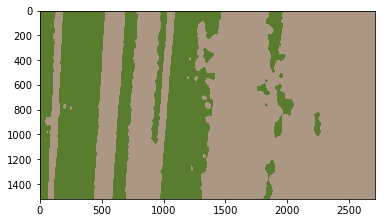

In [31]:
res = np.zeros(img.shape,np.uint8)
for k in range(len(models)):
    res[c==k] = med[k]

imshow(res);

Marcamos los puntos de baja evidencia (negro) y los que no tengan una probabilidad suficienmente alta (rojo).

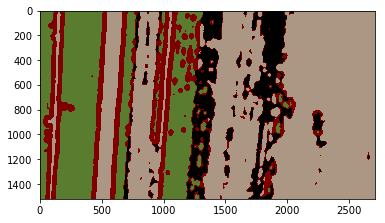

In [32]:
res[mp < 0.99] = 128,0,0
res[E < 0.05] = 0,0,0
imshow(res);

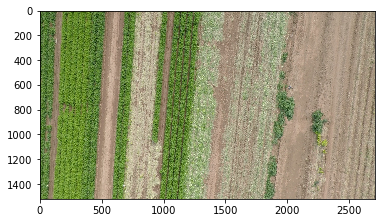

In [33]:
imshow(img);

También se puede obtener una máscara de, p. ej., los píxels de vegetación, lo que permitiría calcular su área o cualquier otra característica de interés.

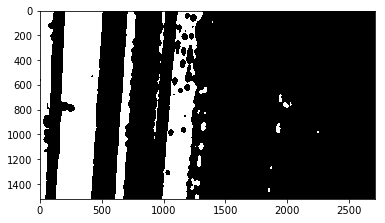

In [34]:
imshow((c == 0) * (E>0.05) * (mp > 0.99)) ;

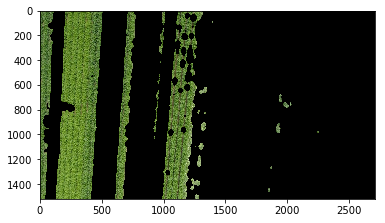

In [35]:
imshow( np.expand_dims( (c == 0) * (E>0.05) * (mp > 0.99) , axis=2) * img );

Cada pixel se ha clasificado de forma independiente, pero realmente habría que tener en cuenta de alguna manera un cierto entorno de cada pixel para tomar una decisión que fuera localmente coherente, produciendo regiones "compactas". Lo hemos hecho mediante el suavizado gaussiano anterior, pero hay formas mejores de hacerlo.

El algoritmo [GrabCut](http://docs.opencv.org/3.2.0/d8/d83/tutorial_py_grabcut.html) optimiza una función objetivo que contiene un término de fidelidad al modelo de color, lo mismo que hemos tenido en cuenta en este ejemplo (aunque usa un modelo de mezcla de gaussianas en vez de un histograma), y otro término que produce un coste en todas las parejas de pixels vecinos que se etiquetan de forma distinta. Lo interesante es que la solución óptima de este problema puede conseguirse de forma eficiente mediante un algoritmo de cortes de grafos ([*graph cuts*](https://en.wikipedia.org/wiki/Graph_cuts_in_computer_vision)).

El ejemplo de código `grabcut.py` es una demo interactiva de este método disponible en OpenCV.

## Tracking

Supongamos que queremos detectar la posicion de un objeto en movimiento en una secuencia de imágenes. Si el objeto es más o menos compacto y tiene un color característico podemos aplicar una técnica similar. A partir de la imagen de verosimilitud del modelo (la reproyección del histograma), podemos obtener la elipse de incertidumbre que engloba la mayor parte del objeto y con ella definir una región de interés del tamaño adecuado para trabajar en el frame siguiente.

Esto es la base de las técnicas [*mean shift* y *cam shift*](http://docs.opencv.org/trunk/db/df8/tutorial_py_meanshift.html). Una demostración de esta técnica se muestra en el ejemplo de código `camshift.py`.

## Otro ejemplo

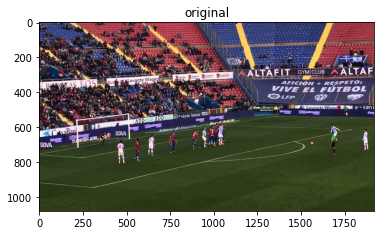

In [54]:
img = readrgb("falta2.jpg")
imshow(img); title('original');
rows,cols,d = img.shape

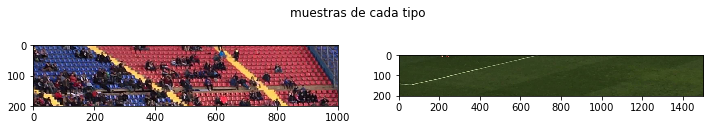

In [37]:
r1 = img[0:200,0:1000]
r2 = img[800:1000,250:1750]
models = [r1,r2]

plt.figure(figsize=(12,2))
plt.subplot(1,2,1); plt.imshow(r1)
plt.subplot(1,2,2); plt.imshow(r2)
plt.suptitle('muestras de cada tipo');

In [38]:
hist = [uvh(r) for r in models]

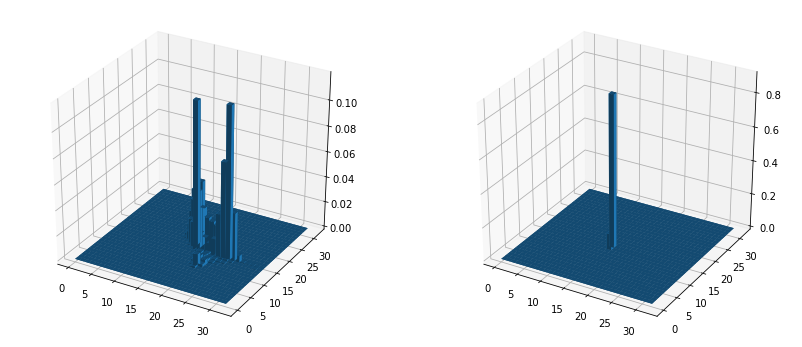

In [39]:
from mpl_toolkits.mplot3d import Axes3D
fg = plt.figure(figsize=(14, 6))

_xx, _yy = np.meshgrid(np.arange(32), np.arange(32))
x, y = _xx.ravel(), _yy.ravel()
bottom = 0
width = depth = 1

ax1 = fg.add_subplot(121, projection='3d')
top = hist[0].ravel()
ax1.bar3d(x, y, bottom, width, depth, top , shade=True);

ax1 = fg.add_subplot(122, projection='3d')
top = hist[1].ravel()
ax1.bar3d(x, y, bottom, width, depth, top, shade=True);

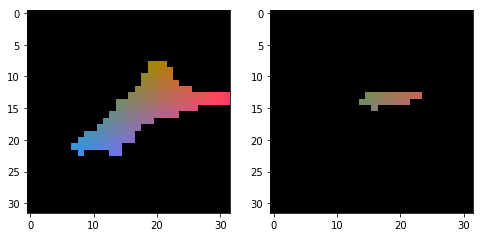

In [40]:
vhist = [ yuv2rgb(uv) * (h > 0).reshape(32,32,1) for h in hist]

fig(8,4)
subplot(1,2,1); imshow(vhist[0]);
subplot(1,2,2); imshow(vhist[1]);

In [41]:
uvr = np.floor_divide( cv.cvtColor(img,cv.COLOR_RGB2YUV)[:,:,[1,2]], 8)

u = uvr[:,:,0]
v = uvr[:,:,1]

lik = [ h[u,v] for h in hist ]

In [42]:
lik = [ cv.GaussianBlur(l, (0,0), 10) for l in lik ]

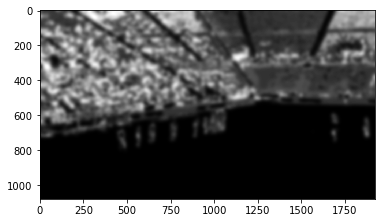

In [43]:
imshow(lik[0], 'gray');

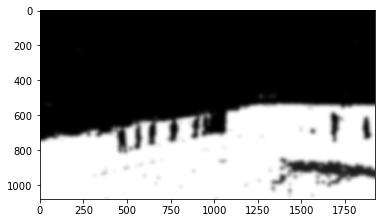

In [44]:
imshow(lik[1], 'gray');

In [45]:
E = np.sum(lik, axis=0)
p = np.array(lik) / E

In [46]:
c  = np.argmax(p,axis=0)

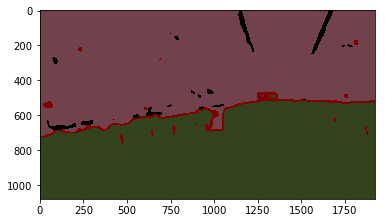

In [47]:
mp = np.max(p, axis=0)
mp[E < 0.01] = 0

res = np.zeros(img.shape,np.uint8)

med = [ np.mean(r,(0,1)) for r in models ]

for k in range(len(models)):
    res[c==k] = med[k]

res[mp < 0.8] = 128,0,0
res[E < 0.01] = 0,0,0
imshow(res);